In [1]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from compartment import SIRModel, SEIRModel
from util import BinomialApprox, ExponentialRandomWalk, plot_samples

## Model: SEIR model for new cases with random parameters/observations, deterministic dynamics

In [107]:
def SEIR_dynamics(T, params, x0, confirmed=None, suffix=""):

    '''
    Run SEIR dynamics for T time steps
    '''
    
    beta0, sigma, gamma, det_rate, det_conc, drift_scale = params

    beta = numpyro.sample("beta" + suffix, 
                  ExponentialRandomWalk(loc=beta0, scale=drift_scale, num_steps=T-1))

    # Run simulation using ODE solve
    
    SEIR = SEIRModel()
    x = SEIR.run(T, x0, (beta, sigma, gamma))
    x = x[1:] # first entry duplicates x0
    numpyro.deterministic("x" + suffix, x)

    latent = x[:,4]

    if confirmed is None:
        obs = None
        mask = True
    else:
        obs = confirmed[1:]
        # Workaround for a jax issue: replace bad observations. See https://forum.pyro.ai/t/behavior-of-mask-handler-with-invalid-observation-possible-bug/1719/5?u=sheldon
        mask = (obs > 0) & (obs < latent)        
        obs = np.where(mask, obs, 0.5 * latent)

    d = BinomialApprox(latent, det_rate * np.ones(T-1), det_conc)

    with numpyro.handlers.mask(mask):
        y = numpyro.sample("y" + suffix, d, obs = obs)

    return beta, x, y


def SEIR_stochastic(T = 50,
                    N = 1e5,
                    T_future = 0,
                    E_duration_mean = 4.0,
                    I_duration_mean = 1.5,
                    R0_mean = 3.5,
                    beta_shape = 1,
                    sigma_shape = 20,
                    gamma_shape = 20,
                    det_rate_mean = 0.3,
                    det_rate_conc = 50,
                    det_conc = 1000,
                    drift_scale = 5e-2,
                    confirmed = None):

    '''
    Stochastic SEIR model. Draws random parameters and runs dynamics.
    '''

    # Sample initial number of infected individuals
    I0 = numpyro.sample("I0", dist.Uniform(0, 0.02*N))
    E0 = numpyro.sample("E0", dist.Uniform(0, 0.02*N))
        
#     # Guess exposed = 10 * infected
#     E0 = 10*I0

    # Sample parameters
    sigma = numpyro.sample("sigma", 
                           dist.Gamma(sigma_shape, sigma_shape * E_duration_mean))


    gamma = numpyro.sample("gamma", 
                           dist.Gamma(gamma_shape, gamma_shape * I_duration_mean))    

    beta0 = numpyro.sample("beta0", 
                          dist.Gamma(beta_shape, beta_shape * I_duration_mean/R0_mean))
        
    det_rate = numpyro.sample("det_rate", 
                              dist.Beta(det_rate_mean * det_rate_conc,
                                        (1-det_rate_mean) * det_rate_conc))

    
    SEIR = SEIRModel()

    x0 = SEIR.seed(N, I0, E0)
    numpyro.deterministic("x0", x0)
    
    obs0 = confirmed[0] if confirmed is not None else None
    y0 = numpyro.sample("y0", 
                        BinomialApprox(x0[4], det_rate, det_conc), 
                        obs = obs0)
    
    params = (beta0, sigma, gamma, det_rate, det_conc, drift_scale)
    
    beta, x, y = SEIR_dynamics(T, params, x0, confirmed=confirmed)
    
    x = np.vstack((x0, x))
    y = np.append(y0, y)
    
    if T_future > 0:
        
        params = (beta[-1], sigma, gamma, det_rate, det_conc, drift_scale)
        
        beta_f, x_f, y_f = SEIR_dynamics(T_future+1, params, x[-1,:], suffix="_future")
        
        x = np.vstack((x, x_f))
        y = np.append(y, y_f)
        
    return beta, x, y, det_rate

# Load and Prep Data

In [108]:
import jhu
import covidtracking
import states

# world data
world = jhu.load_world()

pop = {
    'Italy': 60.48e6,
    'US': 3.27e8,
}

data = {
    'Italy': world.Italy.tot,
    'US': world.US.tot
}

# US state data
US = covidtracking.load_us()
traits = states.uga_traits()

state_pop = { k: traits.totalpop[k] for k in traits.index }
state_data = { k: US[k] for k in US.columns.unique(level=0) }

# combine them
data = dict(data, **state_data)
pop = dict(pop, **state_pop)

# Run Inference

In [113]:
place = 'US'

start = pd.Timestamp('2020-03-04')
confirmed = data[place].confirmed[start:]
start = confirmed.index.min()

T = len(confirmed)
N = pop[place]

kernel = NUTS(SEIR_stochastic)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)

E_dur = 4.0
I_dur = 1.5
R0 = 3.5

init = {
    'E0': 1000.,
    'I0': 10000.,
    'sigma': 1 / E_dur,
    'gamma': 1 / I_dur,
    'beta0': R0 / I_dur,
    'beta': np.repeat(R0 / I_dur, T-1),
    'det_rate' : 0.3
}


args = {
    'N': N,
    'T': T,
    'drift_scale': 1e-1,
    'det_conc': 100,
}

mcmc.run(jax.random.PRNGKey(1), 
         confirmed=confirmed.values,
         init_params = init,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Posterior predictive samples for visualization
post_pred = Predictive(SEIR_stochastic, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

sample: 100%|██████████| 2000/2000 [01:46<00:00, 18.79it/s, 511 steps of size 2.32e-02. acc. prob=0.95]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        E0    346.11    243.43    307.80      2.42    647.00    388.07      1.00
        I0    428.00     93.55    409.67    298.08    580.43    425.93      1.00
   beta[0]      1.72      0.44      1.67      1.04      2.38    275.87      1.00
   beta[1]      1.75      0.43      1.71      1.06      2.39    364.32      1.00
   beta[2]      1.79      0.43      1.76      1.05      2.40    398.89      1.00
   beta[3]      1.84      0.43      1.81      1.13      2.47    437.94      1.00
   beta[4]      1.90      0.44      1.84      1.22      2.58    470.92      1.00
   beta[5]      1.96      0.45      1.91      1.32      2.72    427.49      1.00
   beta[6]      2.02      0.46      1.97      1.33      2.76    424.45      1.00
   beta[7]      2.09      0.48      2.05      1.35      2.81    421.54      1.00
   beta[8]      2.16      0.49      2.11      1.35      2.88    422.46      1.00
   beta[9]      2.23      0

# Inspect Results

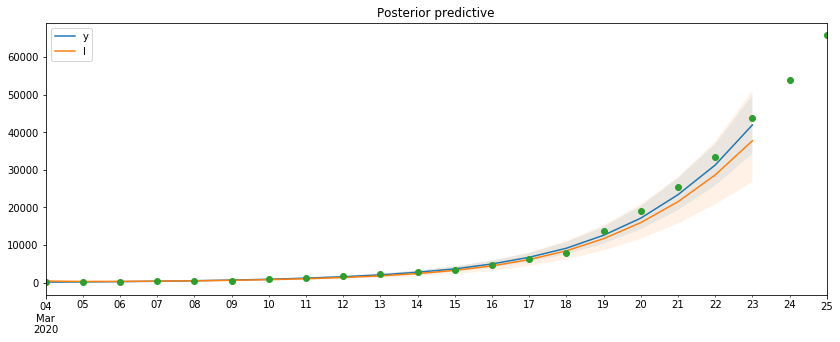

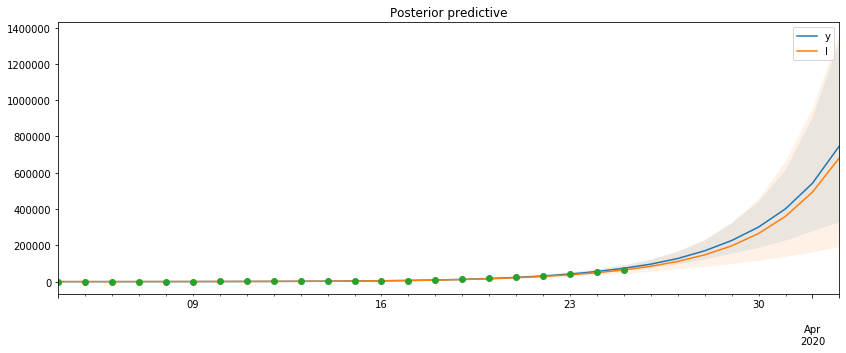

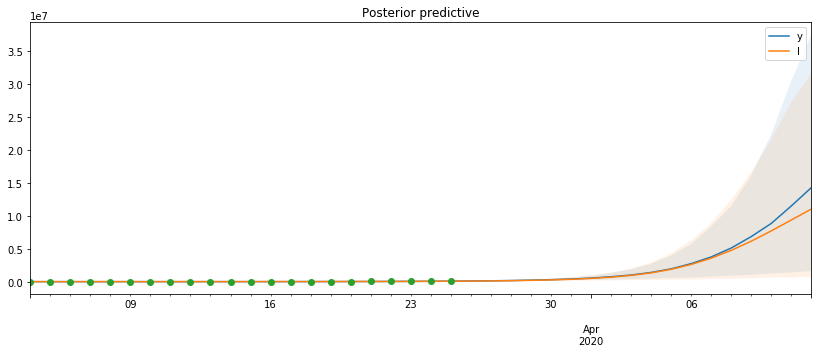

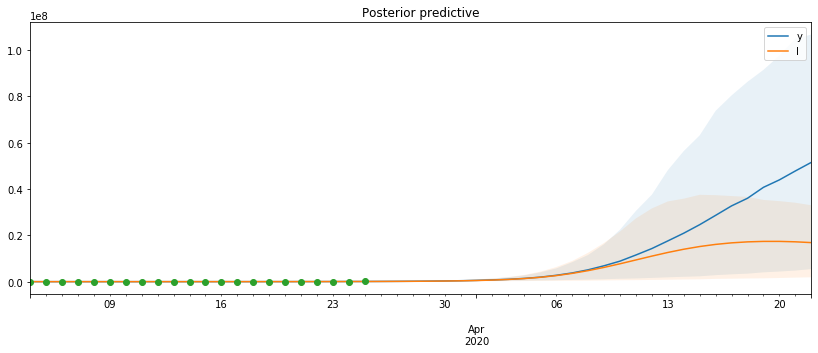

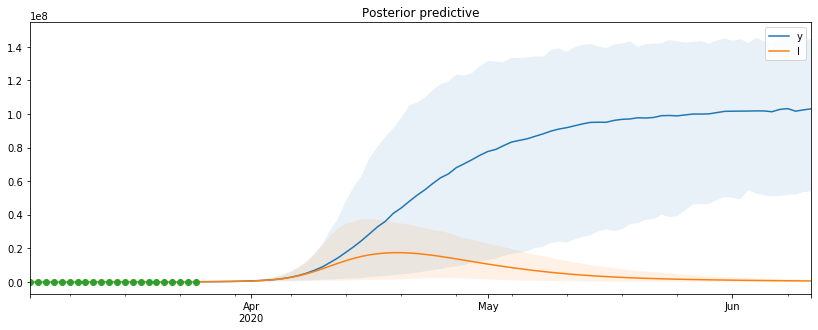

In [116]:
scale = 'lin'

for T in [20, 30, 40, 50, 100]:
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    fig, ax = plt.subplots(figsize=(14,5))
    plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['y', 'I'])
    plt.title('Posterior predictive')
    
    confirmed.plot(style='o')
    
    if scale == 'log':
        plt.yscale('log')
        
    filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    plt.savefig(filename)
    plt.show()

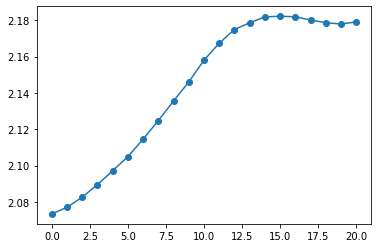

In [111]:
beta = mcmc_samples['beta']
plt.plot(beta.mean(axis=0), '-o')

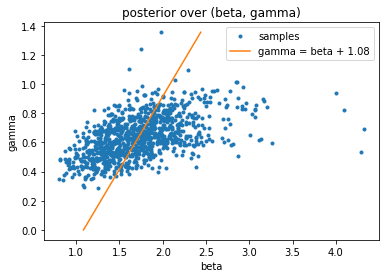

R0: 2.745013


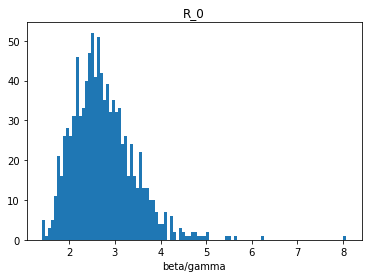

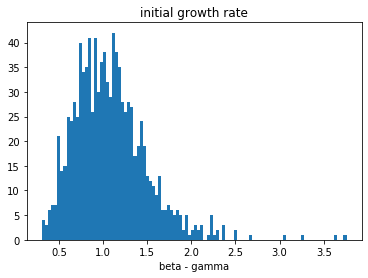

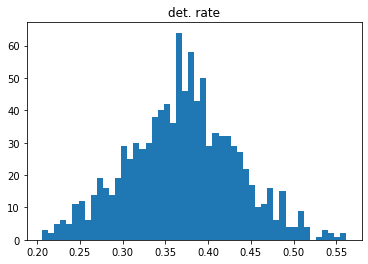

In [117]:
save = False

beta = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = mcmc_samples['beta0'] - mcmc_samples['gamma']
plt.hist(growth_rate, bins=100)
plt.title('initial growth rate')
plt.xlabel('beta - gamma')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

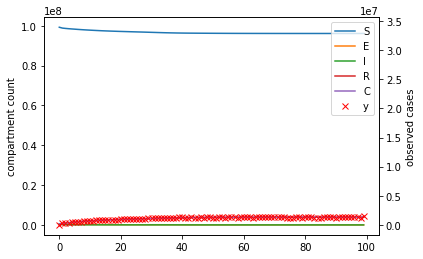

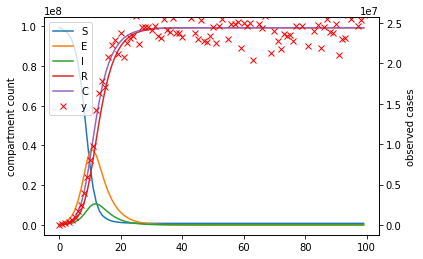

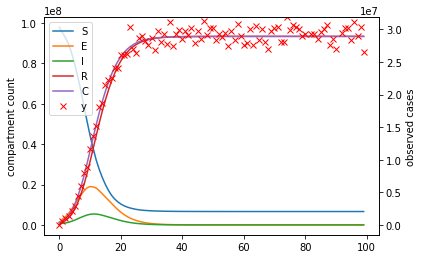

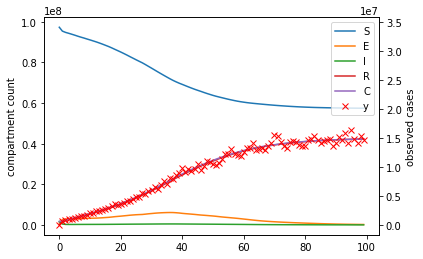

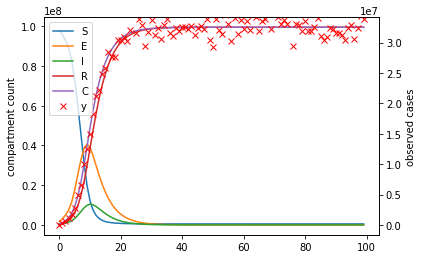

In [5]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, obs_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)    
    l2 = ax2.plot(ts, y, 'x', color='r')
        
    plt.legend(l1 + l2, ['S', 'E', 'I', 'R', 'C', 'y'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=50, T_future=50, N=1e8)
        
    #test_prior_predictive()